In [8]:
# Please set this to the parent folder of this file
setwd("~/Documents/statistical-data-processing-project/model/")


In [9]:
library(ggplot2)
library(tidyverse)
library(janitor)
library("e1071")
source("constants.R")


In [10]:
process_data <- function(data) {
  # Clean column names
  data <- clean_names(data)

  # Hàm để phân loại BMI
  categorize_bmi <- function(bmi) {
    if (bmi < 18.5) {
      return("Underweight")
    } else if (bmi >= 18.5 & bmi < 24.9) {
      return("Normal weight")
    } else if (bmi >= 25 & bmi < 29.9) {
      return("Overweight")
    } else if (bmi >= 30 & bmi < 34.9) {
      return("Obesity class 1")
    } else if (bmi >= 35 & bmi < 39.9) {
      return("Obesity class 2")
    } else {
      return("Obesity class 3")
    }
  }

  # Tạo cột mới bmi_category cho dataframe data
  data$bmi_category <- sapply(data$bmi, categorize_bmi)
  # Chuyển đổi bmi_category thành factor với các levels cụ thể
  data$bmi_category <- factor(data$bmi_category, levels = c("Underweight", "Normal weight", "Overweight", "Obesity class 1", "Obesity class 2", "Obesity class 3"))


  # Xóa các cột không cần thiết
  data <- within(data, rm("bmi", "ment_hlth"))

  # Chuyển đổi các biến không định lượng thành factor
  quantitative_vars <- c("phys_hlth")

  non_quantitative_vars <- setdiff(names(data), quantitative_vars)
  data[non_quantitative_vars] <- lapply(data[non_quantitative_vars], factor)

  return(data)
}

undersampling_data <- process_data(read.csv(file = "../data/undersampled_data.csv"))
oversampling_data <- process_data(read.csv(file = "../data/oversampled_data.csv"))
smote_data <- process_data(read.csv(file = "../data/smote_augmented_data_80_percent.csv"))


In [11]:
glimpse(oversampling_data)


Rows: 555,627
Columns: 21
$ diabetes_012           <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ high_bp                <fct> 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0,…
$ high_chol              <fct> 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,…
$ chol_check             <fct> 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,…
$ smoker                 <fct> 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,…
$ stroke                 <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,…
$ heart_diseaseor_attack <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ phys_activity          <fct> 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,…
$ fruits                 <fct> 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,…
$ veggies                <fct> 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,…
$ hvy_alcohol_consump    <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,…
$ any_healthcare         <fct> 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ no_docbc_cos

In [12]:
train_test_split <- function(data, train_ratio = 0.8) {
  # Đặt seed để đảm bảo tính tái lập
  set.seed(SEED)
  train_indices <- sample(seq_len(nrow(data)), size = floor(train_ratio * nrow(data)), replace = FALSE)
  train_data <- data[train_indices, ]
  test_data <- data[-train_indices, ]
  res <- list(
    train_data = train_data,
    test_data = test_data
  )
  return(res)
}

# Chia train test cho từng bộ dữ liệu
split_undersampling <- train_test_split(undersampling_data)
split_oversampling <- train_test_split(oversampling_data)
split_smote <- train_test_split(smote_data)


In [13]:
cross_validate <- function(train_function, data, k = K) {
  # Đặt seed để đảm bảo tính tái lập
  set.seed(SEED)
  # Create k-folds
  folds <- sample(rep(1:k, length.out = nrow(data)))

  # Initialize a list to store results and models
  results <- list()
  models <- list()

  # Perform cross-validation
  for (i in 1:k) {
    # Split data into training and testing sets
    train_data <- data[folds != i, ]
    test_data <- data[folds == i, ]

    # Train the model on the training set
    model <- train_function(formula = as.formula(paste(TARGET_COLUMN, "~ .")), data = train_data)

    # Predict on the testing set
    predictions <- predict(model, test_data)

    # Calculate accuracy
    accuracy <- mean(predictions == test_data[[TARGET_COLUMN]])

    # Store the result and model
    results[[i]] <- accuracy
    models[[i]] <- model
  }

  return(list(models = models, results = results))
}

# Cross-validation trên tập train
bayes_results_train_undersampling <- cross_validate(naiveBayes, split_undersampling$train_data)
bayes_results_train_oversampling <- cross_validate(naiveBayes, split_oversampling$train_data)
bayes_results_train_smote <- cross_validate(naiveBayes, split_smote$train_data)


In [14]:
accuracy_on_train <- function(results) {
  return(mean(unlist(results$results)))
}

bayes_accuracy_train_undersampling <- accuracy_on_train(bayes_results_train_undersampling)
print(paste(
  "Mean Naive Bayes Accuracy on Train (Undersampling):",
  bayes_accuracy_train_undersampling
))

bayes_accuracy_train_oversampling <- accuracy_on_train(bayes_results_train_oversampling)
print(paste(
  "Mean Naive Bayes Accuracy on Train (Oversampling):",
  bayes_accuracy_train_oversampling
))

bayes_accuracy_train_smote <- accuracy_on_train(bayes_results_train_smote)
print(paste(
  "Mean Naive Bayes Accuracy on Train (SMOTE):",
  bayes_accuracy_train_smote
))


[1] "Mean Naive Bayes Accuracy on Train (Undersampling): 0.505219023926684"
[1] "Mean Naive Bayes Accuracy on Train (Oversampling): 0.518592759081907"
[1] "Mean Naive Bayes Accuracy on Train (SMOTE): 0.546023519646967"


In [17]:
prediction_on_test <- function(results, test_data) {
  best_model <- results$models[[which.max(results$results)]]
  return(predict(best_model, test_data))
}

accuracy_on_test <- function(results, test_data) {
  predictions <- prediction_on_test(results, test_data)
  return(mean(predictions == test_data[[TARGET_COLUMN]]))
}

bayes_accuracy_test_undersampling <- accuracy_on_test(bayes_results_train_undersampling, split_undersampling$test_data)
print(paste(
  "Mean Naive Bayes Accuracy on test (Undersampling):",
  bayes_accuracy_test_undersampling
))

bayes_accuracy_test_oversampling <- accuracy_on_test(bayes_results_train_oversampling, split_oversampling$test_data)
print(paste(
  "Mean Naive Bayes Accuracy on test (Oversampling):",
  bayes_accuracy_test_oversampling
))

bayes_accuracy_test_smote <- accuracy_on_test(bayes_results_train_smote, split_smote$test_data)
print(paste(
  "Mean Naive Bayes Accuracy on test (SMOTE):",
  bayes_accuracy_test_smote
))


[1] "Mean Naive Bayes Accuracy on test (Undersampling): 0.498020870816841"
[1] "Mean Naive Bayes Accuracy on test (Oversampling): 0.518699494267768"
[1] "Mean Naive Bayes Accuracy on test (SMOTE): 0.543374187858827"


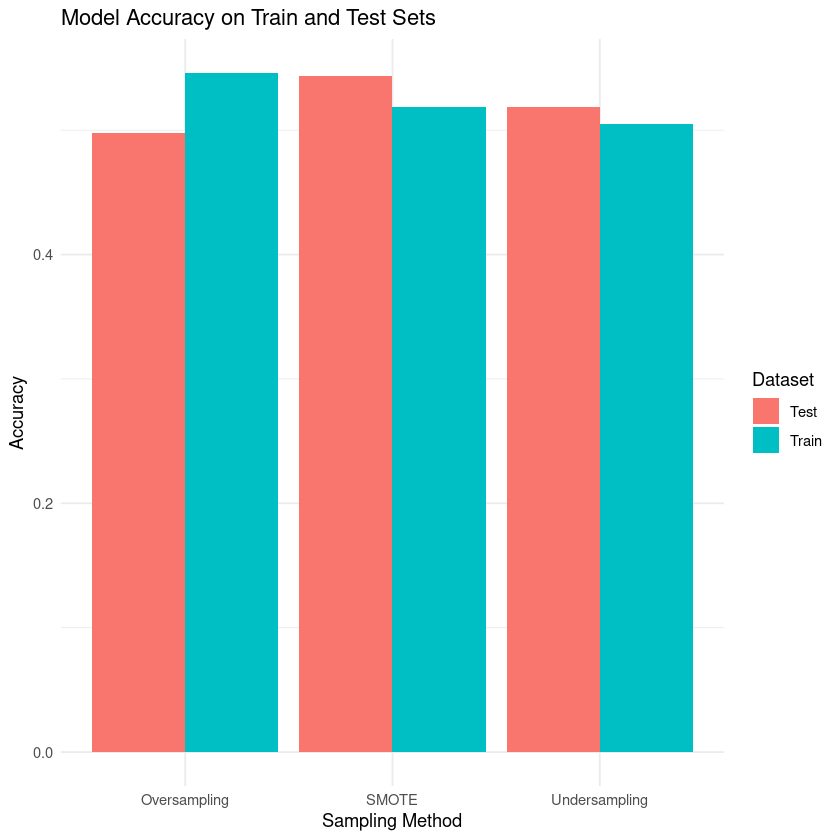

In [18]:
# Tạo dataframe chứa độ chính xác trên train và test
accuracy_data <- data.frame(
    Sampling = rep(c("Undersampling", "Oversampling", "SMOTE"), times = 4),
    Dataset = rep(c("Train", "Test"), times = 6),
    Accuracy = c(
        bayes_accuracy_train_undersampling, bayes_accuracy_test_undersampling,
        bayes_accuracy_train_oversampling, bayes_accuracy_test_oversampling,
        bayes_accuracy_train_smote, bayes_accuracy_test_smote
    )
)

# Vẽ barplot
ggplot(accuracy_data, aes(x = Sampling, y = Accuracy, fill = Dataset)) +
    geom_bar(stat = "identity", position = "dodge") +
    labs(
        title = "Model Accuracy on Train and Test Sets",
        x = "Sampling Method",
        y = "Accuracy"
    ) +
    theme_minimal()


In [19]:
library(caret)
library(ggplot2)
library(reshape2)

# Function to plot confusion matrix
plot_confusion_matrix <- function(predictions, actual, title) {
  cm <- confusionMatrix(predictions, actual)
  cm_table <- as.table(cm)
  cm_df <- as.data.frame(cm_table)
  colnames(cm_df) <- c("Prediction", "Actual", "Freq")

  ggplot(data = cm_df, aes(x = Prediction, y = Actual, fill = Freq)) +
    geom_tile() +
    geom_text(aes(label = Freq), vjust = 1) +
    scale_fill_gradient(low = "white", high = "blue") +
    labs(title = title, x = "Predicted", y = "Actual") +
    theme_minimal()
}


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift



Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




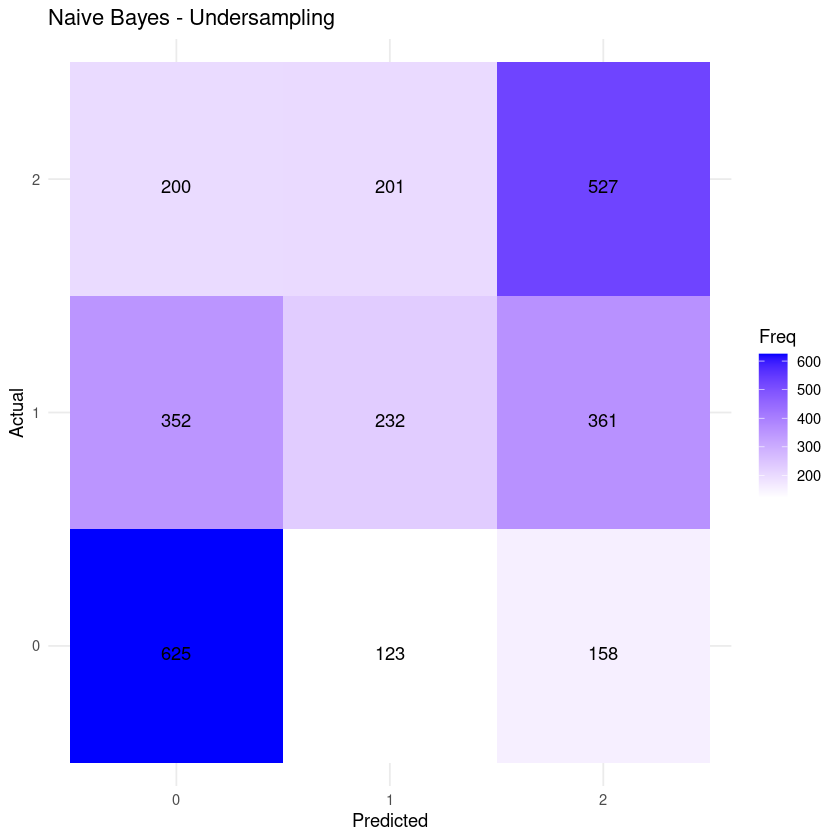

In [20]:
plot_confusion_matrix(
  prediction_on_test(
    bayes_results_train_undersampling,
    split_undersampling$test_data
  ),
  split_undersampling$test_data[[TARGET_COLUMN]],
  "Naive Bayes - Undersampling"
)


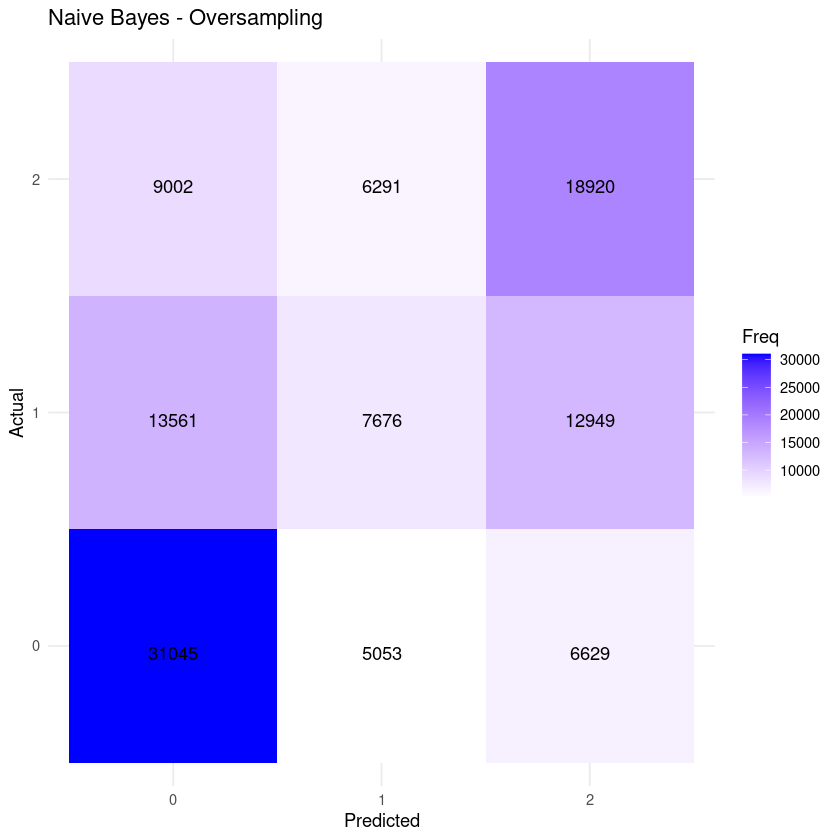

In [21]:
plot_confusion_matrix(
  prediction_on_test(
    bayes_results_train_oversampling,
    split_oversampling$test_data
  ),
  split_oversampling$test_data[[TARGET_COLUMN]],
  "Naive Bayes - Oversampling"
)


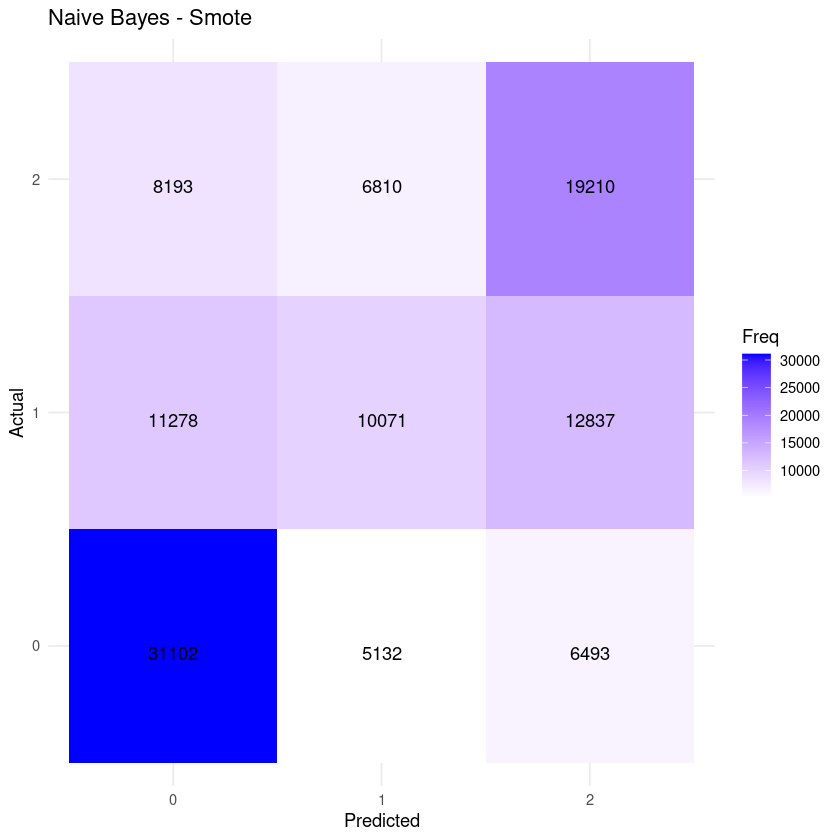

In [22]:
plot_confusion_matrix(
  prediction_on_test(
    bayes_results_train_smote,
    split_smote$test_data
  ),
  split_smote$test_data[[TARGET_COLUMN]],
  "Naive Bayes - Smote"
)
